In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')#使用ggplot样式
%matplotlib inline

In [3]:
from sagas.ofbiz.entities import search_entity
search_entity('order')

OrderItemTypeAttr
OrderItemContactMech
OrderAdjustmentBilling
OrderReportView
OrderHeaderNoteView
OrderItemType
OrderHeaderWorkEffort
TrackingCodeOrderAndOrderHeader
OrderTerm
OrderReportPurchasesGroupByProduct
SupplierPrefOrder
OrderItemAndProductContentInfo
OrderAdjustmentType
OrderAdjustment
OrderItemRole
OrderItemBillingAndInvoiceAndItem
OrderItemAndProduct
MarketingCampaignAndOrderHeader
OrderItemAssoc
OrderItemChange
OrderHeaderAndShipGroupsByProduct
OrderItemShipGroup
OrderItemShipGrpInvResAndItem
TrackingCodeOrderReturn
OrderHeaderAndShipGroups
WorkEffortOrderHeaderView
OrderItemQuantityReportGroupByItem
OrderItemShipGrpInvResAndItemLocation
PackedQtyVsOrderItemQuantity
OrderItemAndShipGrpInvResAndItem
OrderContactMech
OrderContent
OrderHeaderAndItems
OrderHeaderItemAndInv
OrderItemAndShipGrpInvResAndItemSum
OrderHeaderItemAndInvRoles
OrderItemGroup
OrderHeaderAndWorkEffort
TrackingCodeOrder
OrderShipment
OrderType
OrderHeader
OrderItemAttribute
OrderItemAssocType
OrderDelivery

In [5]:
import networkx as nx
G = nx.Graph()

In [62]:
from sagas.ofbiz.entities import oc,finder,OfEntity
from sagas.util.str_converters import to_camel_case, to_snake_case

def create_model_graph():
    G = nx.Graph()
    model_reader=oc.delegator.getModelReader()
    names=model_reader.getEntityNames()
    edges = []
    for entity_name in names:
        ent=oc.delegator.getModelEntity(entity_name)
        for rel in ent.getRelationsList(True, True, True):
            weight=0.5 if rel.getType()=="many" else 1.0
            edges.append((to_snake_case(entity_name), 
                          to_snake_case(rel.getRelEntityName()), 
                          weight))

    G.clear()
    G.add_weighted_edges_from(edges)
    return G

G=create_model_graph()
print(len(G.nodes))

944


In [22]:
print(nx.dijkstra_path(G, 'person', 'order_header'))
print(nx.dijkstra_path(G, 'party', 'order_header'))
print(nx.dijkstra_path(G, 'person', 'order_item'))
print(nx.dijkstra_path(G, 'party', 'order_item'))

['person', 'shipment', 'order_header']
['party', 'shipment', 'order_header']
['person', 'user_login', 'order_item']
['party', 'fin_account_trans', 'order_item']


In [46]:
import re
def to_words(camel_str, capfirst=False):
    snake_str=to_snake_case(camel_str)
    components = snake_str.split("_")
    return " ".join(components)
    
def get_relations(from_ent, to_ent):
    from_ent=to_camel_case(from_ent, True)
    to_ent=to_camel_case(to_ent, True)
    # print("rel", from_ent, to_ent)
    rels=[]
    ent=oc.delegator.getModelEntity(from_ent)
    for rel in ent.getRelationsList(True, True, True):
        if to_ent==rel.getRelEntityName():
            rels.append((rel.getType(), rel.getTitle()+rel.getRelEntityName()))
    return rels

In [64]:
g=create_model_graph()

person shipment [('many', 'ToShipment'), ('many', 'FromShipment')]
shipment order_header [('one', 'PrimaryOrderHeader')]


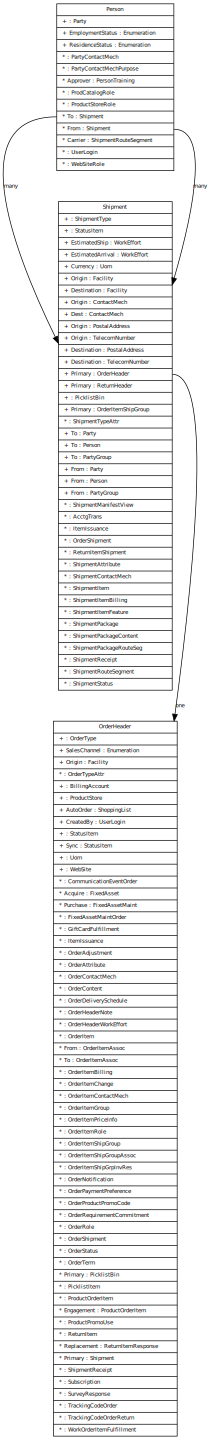

In [102]:
from graphviz import Digraph, Graph

def set_graph_attributes(t):
    t.attr('node', fontsize='8.0', fontname="Menlo")
    t.attr('edge', fontsize='8.0', fontname="Bitstream Vera Sans")
    t.attr('node', shape='record')

def build_entity_descriptor(ent_name):
    ent_name=to_camel_case(ent_name, True)
    ent=oc.delegator.getModelEntity(ent_name)
    lines=["{<el>"+ent_name]
    for rel in ent.getRelationsList(True, True, True):
        lines.append("|<{name}>{rel_type} {title} : {entity}\l".format(
            entity=rel.getRelEntityName(),
            rel_type="*" if rel.getType()=="many" else "+",
            name=rel.getTitle()+rel.getRelEntityName(),
            title=rel.getTitle()
            ))
    lines.append("}")
    return "".join(lines)

def build_graph(g, from_entity, to_entity):    
    # e = Graph('G', filename='process.gv', engine='fdp', format='png')
    e = Digraph('EntityModelGraph')
    # e = Digraph('ER', filename='er.gv', engine='neato')
    set_graph_attributes(e)    
    e.attr(size='20,20')
    # e.node_attr.update(color='lightblue2', style='filled')

    # nx.draw_shell(G)
    path=nx.dijkstra_path(g, from_entity, to_entity)
    for ent in path:    
        e.node(ent, build_entity_descriptor(ent))

    for index in range(1,len(path)):
        from_ent=path[index-1]
        to_ent=path[index]
        rels=get_relations(from_ent,to_ent)
        print(from_ent, to_ent, rels)   

        # e.attr('node', shape='diamond', style='filled', color='lightgrey')
        e.attr('node', shape='box', fontsize='8.0', 
               style='filled', color='lightgrey', 
               height='0.25', fontname="times:italic")
        for rel in rels:
            # rel_ent=to_words(rel[1])
            rel_ent=rel[1]
            e.edge(from_ent+":"+rel_ent, to_ent, label=rel[0])
        # u.edge(from_ent, to_ent)
    return e

build_graph(g, 'person', 'order_header')

person shipment [('many', 'ToShipment'), ('many', 'FromShipment')]
shipment order_header [('one', 'PrimaryOrderHeader')]


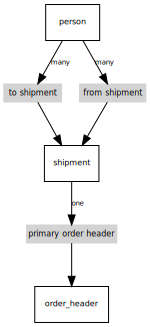

In [82]:
from graphviz import Digraph

def build_graph(g, from_entity, to_entity):
    e = Digraph('unix', filename='unix.gv')
    # e = Digraph('ER', filename='er.gv', engine='neato')
    # e.attr(size='6,6')
    # e.node_attr.update(color='lightblue2', style='filled')

    # nx.draw_shell(G)
    path=nx.dijkstra_path(g, from_entity, to_entity)
    # e.attr('node', shape='ellipse', fontsize='10.5')
    set_graph_attributes(e)
    e.attr('edge', fontsize='7.0')
    for ent in path:    
        e.node(ent)

    for index in range(1,len(path)):
        from_ent=path[index-1]
        to_ent=path[index]
        rels=get_relations(from_ent,to_ent)
        print(from_ent, to_ent, rels)   

        # e.attr('node', shape='diamond', style='filled', color='lightgrey')
        e.attr('node', shape='box', fontsize='8.0', 
               style='filled', color='lightgrey', 
               height='0.25', fontname="times:italic")
        for rel in rels:
            rel_ent=to_words(rel[1])
            e.node(rel_ent)
            e.edge(from_ent, rel_ent, label=rel[0], len='1.00')
            e.edge(rel_ent, to_ent, label=' ', len='1.00')
        # u.edge(from_ent, to_ent)
    return e

build_graph(g, 'person', 'order_header')

In [20]:
from sagas.ofbiz.entities import OfEntity as e
e('relations').Person

,entity name,relation,type,relation type
0,Party,Party,one,one
1,Enumeration,EmploymentStatusEnumeration,one,one
2,Enumeration,ResidenceStatusEnumeration,one,one
3,PartyContactMech,PartyContactMech,many,many
4,PartyContactMechPurpose,PartyContactMechPurpose,many,many
5,PersonTraining,ApproverPersonTraining,many,many
6,ProdCatalogRole,ProdCatalogRole,many,many
7,ProductStoreRole,ProductStoreRole,many,many
8,Shipment,ToShipment,many,many
9,Shipment,FromShipment,many,many


In [71]:
to_camel_case('ProdCatalogRole')

'ProdCatalogRole'